# Early Intervention Efficacy Model

In [1]:
# Import modules and set options
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(context='notebook', style='ticks')

Import data

In [2]:
lsl_dr = (pd.read_csv('../data/clean/lsl_dr.csv', index_col=0, low_memory=False)
                  .rename({'onset_1':'identify_mo'}, axis=1))

In [3]:
lsl_dr.head()

,redcap_event_name,academic_year_rv,hl,male,_race,prim_lang,sib,_mother_ed,father_ed,parent_hl,...,domain,eowpvt_ss,evt_ss,gf2_ss,ppvt_ss,rowpvt_ss,school,score,test_name,test_type
0,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,0.0,...,Expressive Vocabulary,58.0,NaN,NaN,NaN,NaN,101,58.0,NaN,EOWPVT
1,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,0.0,...,Language,NaN,NaN,NaN,NaN,NaN,101,51.0,PLS,receptive
2,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,0.0,...,Language,NaN,NaN,NaN,NaN,NaN,101,60.0,PLS,expressive
3,initial_assessment_arm_1,2009.0,0.0,1.0,2.0,0.0,1.0,2.0,6.0,0.0,...,Articulation,NaN,NaN,97.0,NaN,NaN,628,97.0,NaN,Goldman
4,initial_assessment_arm_1,2009.0,0.0,1.0,2.0,0.0,1.0,2.0,6.0,0.0,...,Language,NaN,NaN,NaN,NaN,NaN,628,47.0,CELF-4,receptive


Indicator for non-profound hearing loss

In [4]:
lsl_dr['deg_hl_below6'] = lsl_dr.degree_hl<6
lsl_dr.loc[lsl_dr.degree_hl.isnull(), 'deg_hl_below6'] = np.nan

Indicator for first intervention outside OPTION

In [5]:
lsl_dr['int_outside_option'] = lsl_dr.age > lsl_dr.age_int
lsl_dr.loc[lsl_dr.age < lsl_dr.age_int, 'int_outside_option'] = np.nan

Indicator for high school graduation of mother

In [6]:
lsl_dr['mother_hs'] = lsl_dr.mother_ed > 1
lsl_dr.loc[lsl_dr.mother_ed.isnull(), 'mother_hs'] = None

Create age in years variable

In [7]:
lsl_dr['age_years'] = lsl_dr.age/12.

Create school index

In [8]:
schools_unique = np.sort(lsl_dr.school.unique())
school_lookup = dict(zip(schools_unique, range(len(schools_unique))))

In [9]:
lsl_dr['school_idx'] = lsl_dr.school.replace(school_lookup)

Create student index

In [10]:
student_unique = np.sort(lsl_dr.study_id.unique())
student_lookup = dict(zip(student_unique, range(len(student_unique))))

In [11]:
lsl_dr['student_idx'] = lsl_dr.study_id.replace(student_lookup)

### Exclusions

Drop non-english and other disabilities, filter for hearing loss

In [12]:
exclusion_mask = (~lsl_dr.non_english.astype(bool) 
                  & ~lsl_dr.synd_or_disab.astype(bool) 
                  & (lsl_dr.degree_hl!=0))

In [13]:
covariates = ['score', 'student_idx', 'school_idx', 'male', 'sib', 'family_inv', 'race', 'age_test', 
              'domain', 'deg_hl_below6', 'mother_hs', 'age_years', 'test_type']

In [189]:
analysis_subset = lsl_dr.loc[exclusion_mask, covariates].copy()
analysis_subset.shape

(25586, 13)

## Summary Statistics

In [190]:
unique_students = analysis_subset.drop_duplicates(subset='student_idx')
unique_students.shape

(3133, 13)

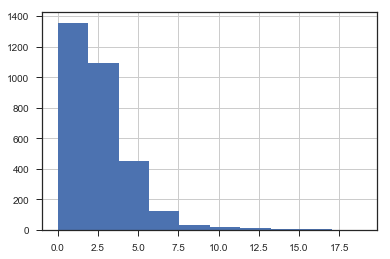

In [191]:
unique_students.age_years.hist()

In [192]:
unique_students.male.mean()

0.51867219917012453

In [195]:
unique_students.domain.value_counts()

Articulation             1410
Language                 1073
Expressive Vocabulary     597
Receptive Vocabulary       53
Name: domain, dtype: int64

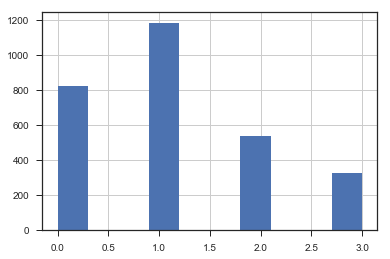

In [196]:
unique_students.sib.hist()

In [197]:
unique_students.deg_hl_below6.mean()

0.54571843251088537

In [198]:
unique_students.mother_hs.mean()

0.57186389029964446

Add expressive and receptive to langauge test domains

In [199]:
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='receptive'), 
           'domain'] = 'Receptive Language'
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='expressive'), 
           'domain'] = 'Expressive Language'

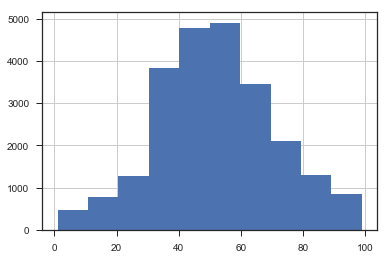

In [200]:
analysis_subset[analysis_subset.age_test<100].age_test.hist()

In [201]:
(analysis_subset.isnull().sum() / analysis_subset.shape[0]).round(2)

score            0.00
student_idx      0.00
school_idx       0.00
male             0.00
sib              0.07
family_inv       0.15
race             0.01
age_test         0.00
domain           0.00
deg_hl_below6    0.09
mother_hs        0.34
age_years        0.01
test_type        0.00
dtype: float64

Drop records with missing race and age at ernollment, since there is less than 1% of them

In [203]:
analysis_subset = analysis_subset.dropna(subset=['race', 'age_years'])

In [204]:
analysis_subset.race.value_counts()

0.0    15539
1.0     3080
2.0     2608
4.0     2465
3.0     1311
Name: race, dtype: int64

## Receptive Language Test Score Model

In [205]:
receptive_language_dataset = analysis_subset[(analysis_subset.domain=='Receptive Language')]

receptive_language_dataset.head()

,score,student_idx,school_idx,male,sib,family_inv,race,age_test,domain,deg_hl_below6,mother_hs,age_years,test_type
1,51.0,0,0,0.0,1.0,2.0,0.0,54.0,Receptive Language,0.0,NaN,4.333333,receptive
18,113.0,2884,26,1.0,0.0,0.0,2.0,92.0,Receptive Language,1.0,1.0,0.916667,receptive
21,96.0,2885,26,0.0,0.0,1.0,0.0,85.0,Receptive Language,0.0,1.0,1.583333,receptive
26,61.0,2888,26,1.0,1.0,1.0,1.0,101.0,Receptive Language,1.0,1.0,2.416667,receptive
29,96.0,2889,26,0.0,0.0,2.0,0.0,85.0,Receptive Language,0.0,1.0,1.750000,receptive


This is the size of the resulting dataset to be used in this analysis

In [206]:
receptive_language_dataset.shape

(5289, 13)

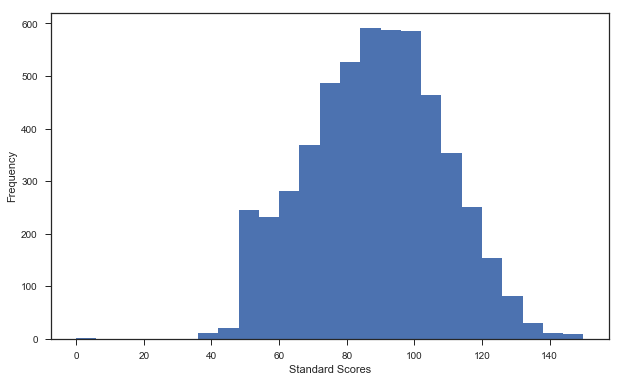

In [207]:
receptive_language_dataset.score.hist(grid=False, bins=25, figsize=(10, 6))
plt.xlabel('Standard Scores'); plt.ylabel('Frequency');

Final analysis dataset size

In [208]:
receptive_language_dataset.shape

(5289, 13)

In [209]:
receptive_language_dataset.race.value_counts()

0.0    3263
1.0     684
2.0     553
4.0     514
3.0     275
Name: race, dtype: int64

In [210]:
def fillna(x, value):
    x_masked = masked_invalid(x)
    set_fill_value(x_masked, value)
    return x_masked

fillna(np.array([0.4, np.nan, 5]), 0.5)

masked_array(data = [0.4 -- 5.0],
             mask = [False  True False],
       fill_value = 0.5)

In [224]:
from pymc3 import Bernoulli, Normal, Uniform, Dirichlet, Categorical, Beta, HalfCauchy, Exponential, Multinomial
from pymc3 import Model, Deterministic, Metropolis
from numpy.ma import masked_values, set_fill_value, masked_invalid
import theano.tensor as tt
from theano import shared

def generate_model(dataset, cohort_age):
    
    if cohort_age==2:
        mask = (dataset.age_test>=24) & (dataset.age_test<36)
    elif cohort_age==3:
        mask = (dataset.age_test>=36) & (dataset.age_test<48)
    elif cohort_age==4:
        mask = (dataset.age_test>=48) & (dataset.age_test<60)
    elif cohort_age==5:
        mask = (dataset.age_test>=60) & (dataset.age_test<72)
    elif cohort_age==6:
        mask = (dataset.age_test>=72) & (dataset.age_test<84)
    else:
        print('Invalid age!')
        return
    
    # Generate mean scores
    mean_scores = dataset[mask].groupby('student_idx').score.mean()
    dataset_unique = dataset[mask].drop_duplicates(subset='student_idx')
    dataset_unique.set_index('student_idx').drop('score', axis=1).join(mean_scores)
    assert not dataset_unique.score.isnull().sum()
    
    (male, sib, family_inv, race, school,
             non_severe, mom_hs, age_enroll, score) = dataset_unique[['male', 'sib','family_inv', 'race', 'school_idx',
                                                    'deg_hl_below6', 'mother_hs', 
                                                    'age_years', 'score']].T.values
    
    # Transform some data
    age_enroll_std = age_enroll - age_enroll.mean()

    with Model() as model:

        # Imputation of family involvement
        if np.isnan(family_inv).sum():
            p_family_inv = Dirichlet("p_family_inv", np.ones(5))
            x_family_inv = Categorical('x_family_inv', p_family_inv, 
                                       observed=masked_invalid(family_inv))
        else:
            x_family_inv = family_inv
        
        # Imputation of hearing loss
        if np.isnan(non_severe).sum():
            p_hl = Beta("p_hl", 1, 1, testval=0.9)
            x_hl = Bernoulli('x_hl', p_hl, observed=masked_invalid(non_severe))
        else:
            x_hl = non_severe
            
        # Imputation of maternal education
        if np.isnan(mom_hs).sum():
            p_mother_hs = Beta("p_mother_hs", 1, 1)
            x_mother_hs = Bernoulli('x_mother_hs', p_mother_hs, 
                                    observed=masked_values(fillna(mom_hs, 0.5), value=0.5))
        else:
            x_mother_hs = mom_hs

        # Imputation of siblings
        if np.isnan(sib).sum():
            n_sib_cats = len(dataset.sib.unique())
            p_sib = Dirichlet("p_sib", np.ones(n_sib_cats))
            x_sib = Categorical('x_sib', p_sib, observed=masked_values(fillna(sib, 0.5), value=0.5))
        else:
            x_sib = sib
            
        # Indices to school random effects
        unique_schools = np.unique(school)
        school_index = [list(unique_schools).index(s) for s in school]

        # School random effect
        μ_school = Normal('μ_school', 100, sd=100)
        σ_school = HalfCauchy("σ_school", 1)
        z_school = Normal('z_school', mu=0, sd=1, shape=len(unique_schools))
        α_school = Deterministic("α_school", μ_school + z_school*σ_school)
        
        # Random intercepts
        intercept = α_school[school_index]
        
        # Race effect
        β_race = Normal("β_race", 0, sd=10, shape=4)
        race_effect = tt.concatenate([[0], β_race])[race.astype(int)]
        
        X = [male, x_family_inv, x_sib, x_hl, x_mother_hs, age_enroll_std]
        # Fixed effects
        β = Normal("β", 0, sd=100, shape=len(X))
        θ = intercept + race_effect + β.dot(tt.stack(X))
    
        σ = HalfCauchy("σ", 5, testval=100)
        score_like = Normal("score_like", mu=θ, sd=σ, observed=score)
        
        # Predictions:
        [male, x_family_inv, x_sib, x_hl, x_mother_hs, age_enroll_std]
        # Caucasian girl, normal family involvement, 
        # 2 siblings, non-profound hearing loss,
        # mother with HS, average age
        x1 = [0, 1, 2, 1, 1, 0]

        # Hispanic boy, ideal family involvement, 
        # no siblings, profound hearing loss,
        # mother without HS diploma, 6 months younger than average
        x2 = [1, 0, 0, 1, 0, -0.5]

        # Black boy, poor family involvement, 
        # 1 sibling, non-profound hearing loss,
        # mother without HS diploma, 1.5 years older than average
        x3 = [1, 4, 1, 0, 0, 1.5]

        # Black girl, impaired family involvement, 
        # 3 siblings, profound hearing loss,
        # mother with HS diploma, 6 months older than average
        x4 = [0, 3, 3, 1, 1, 0.5]

        X_new = tt.stack([x1, x2, x3, x4])

        θ_pred = μ_school + β.dot(X_new.T) + β_race[np.array([0,2,1,1])]
        predictions = Normal('predictions', mu=θ_pred, sd=σ, shape=4)
    
    return model

### Making predictions

Though these models were constructed primarily for inference, that is, to provide insights on the relative effects of a suite of factors on expected test scores, there is the potential for using them to predict speech-language outcomes. To explore this, we contrived four predictive scenarios, whereby children with different values of the set of predictor variables were specified, and predictions for them were generated by our models. 

The Bayesian hierarchical modeling approach makes generating predictions straightforward, via the posterior predictive distribution, which generates predicted values of outcomes conditional on the outcomes observed in the dataset. The variation of these predictions includes both the residual uncertainty in the model parameters and the aleatory sampling variability of the test outcomes. Our test cases were specified as follows:

**Case 1** 👧

* female
* average age
* normal family involvement
* 2 siblings
* non-profound hearing loss
* mother with HS
* no previous disability
* JCIH criterion met

**Case 2** 👦

* male 
* 6 months younger than average
* normal family involvement
* no siblings
* profound hearing loss
* mother without HS diploma
* previous disability
* JCIH criterion met

**Case 3** 👶

* male 
* 1.5 years older than average
* poor family involvement
* 1 sibling
* non-profound hearing loss
* mother without HS diploma
* previous disability
* no JCIH

**Case 4** 🙎

* female 
* 6 months older than average
* impaired family involvement
* 3 siblings
* profound hearing loss
* mother with HS diploma
* no previous disability
* JCIH criterion met

In [225]:
receptive_language_4 = generate_model(receptive_language_dataset, 4)

In [228]:
iterations = 1000
tuning = 1000

In [229]:
from pymc3 import sample

with receptive_language_4:
    
    trace = sample(iterations, tune=tuning)

Assigned NUTS to p_family_inv_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_family_inv_missing
Assigned NUTS to p_hl_logodds__
Assigned BinaryGibbsMetropolis to x_hl_missing
Assigned NUTS to p_mother_hs_logodds__
Assigned BinaryGibbsMetropolis to x_mother_hs_missing
Assigned NUTS to p_sib_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_sib_missing
Assigned NUTS to μ_school
Assigned NUTS to σ_school_log__
Assigned NUTS to z_school
Assigned NUTS to β_race
Assigned NUTS to β
Assigned NUTS to σ_log__
Assigned NUTS to predictions
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|██████████| 2000/2000 [28:13<00:00,  1.18it/s]


In [230]:
labels = ['Male', 
          'Family Involvement Score', 
          'Sibling Count',
          'Non-profound Hearing Loss',
          'Mother with HS Diploma',
          'Age at enrollment']

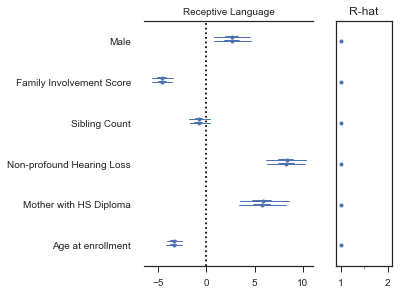

In [231]:
from pymc3 import forestplot

forestplot(trace, varnames=['β'], ylabels=labels, main='Receptive Language')

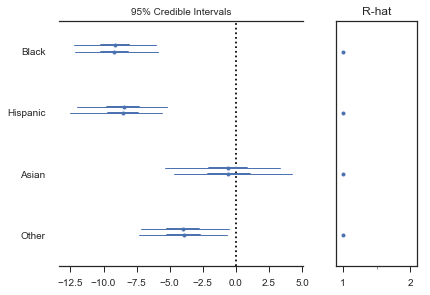

In [232]:
forestplot(trace, varnames=['β_race'], ylabels=['Black', 'Hispanic', 'Asian', 'Other'])

In [235]:
from pymc3 import summary

summary(trace, varnames=['β']).set_index(pd.Index(labels))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Male,2.652669,1.000587,0.014732,0.736940,4.555720,2000.0,0.999609
Family Involvement Score,-4.587213,0.564417,0.012767,-5.667116,-3.502038,2000.0,0.999599
Sibling Count,-0.775128,0.543741,0.008943,-1.841366,0.294595,2000.0,0.999584
Non-profound Hearing Loss,8.287442,1.072897,0.016954,6.227944,10.252352,2000.0,0.999517
Mother with HS Diploma,5.800695,1.280359,0.029186,3.402891,8.387999,2000.0,0.999659
Age at enrollment,-3.389412,0.398939,0.007940,-4.147178,-2.557329,2000.0,0.999901


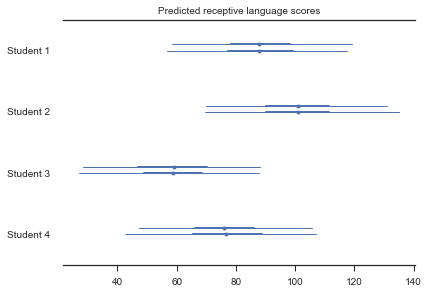

In [236]:
forestplot(trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Expressive Language Model

In [237]:
expressive_language_dataset = analysis_subset[(analysis_subset.domain=='Expressive Language')]

In [238]:
expressive_language_4 = generate_model(expressive_language_dataset, 4)

In [239]:
with expressive_language_4:
    
    exp_lang_4_trace = sample(iterations, tune=tuning)

Assigned NUTS to p_family_inv_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_family_inv_missing
Assigned NUTS to p_hl_logodds__
Assigned BinaryGibbsMetropolis to x_hl_missing
Assigned NUTS to p_mother_hs_logodds__
Assigned BinaryGibbsMetropolis to x_mother_hs_missing
Assigned NUTS to p_sib_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_sib_missing
Assigned NUTS to μ_school
Assigned NUTS to σ_school_log__
Assigned NUTS to z_school
Assigned NUTS to β_race
Assigned NUTS to β
Assigned NUTS to σ_log__
Assigned NUTS to predictions
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|██████████| 2000/2000 [31:23<00:00,  1.06it/s]


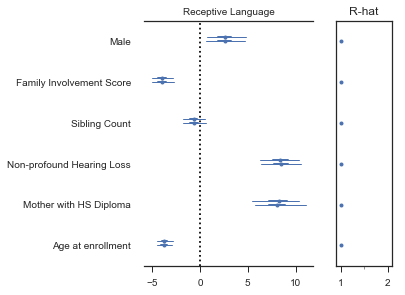

In [240]:
forestplot(exp_lang_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

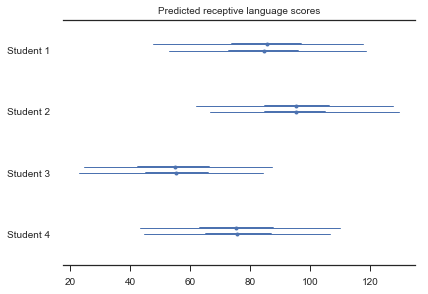

In [241]:
forestplot(exp_lang_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Articulation Model

In [242]:
articulation_dataset = analysis_subset[(analysis_subset.domain=='Articulation')]

In [243]:
articulation_4 = generate_model(articulation_dataset, 4)

In [244]:
with articulation_4:
    
    artic_4_trace = sample(iterations, tune=tuning)

Assigned NUTS to p_family_inv_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_family_inv_missing
Assigned NUTS to p_hl_logodds__
Assigned BinaryGibbsMetropolis to x_hl_missing
Assigned NUTS to p_mother_hs_logodds__
Assigned BinaryGibbsMetropolis to x_mother_hs_missing
Assigned NUTS to p_sib_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_sib_missing
Assigned NUTS to μ_school
Assigned NUTS to σ_school_log__
Assigned NUTS to z_school
Assigned NUTS to β_race
Assigned NUTS to β
Assigned NUTS to σ_log__
Assigned NUTS to predictions
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|██████████| 2000/2000 [36:55<00:00,  1.11s/it]


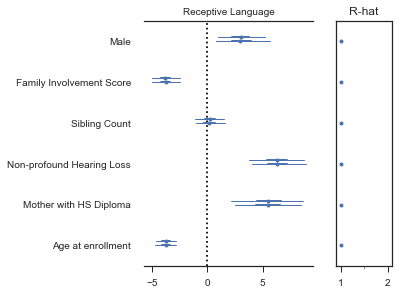

In [245]:
forestplot(artic_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

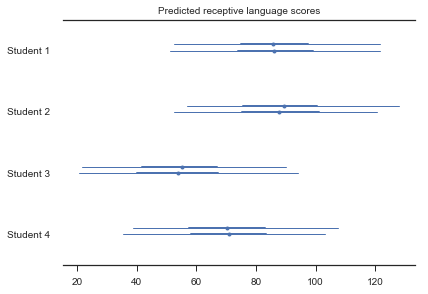

In [246]:
forestplot(artic_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Expressive Vocabulary Model

In [247]:
expressive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Expressive Vocabulary')]

In [248]:
expressive_vocab_4 = generate_model(expressive_vocab_dataset, 4)

In [249]:
with expressive_vocab_4:
    
    expressive_vocab_4_trace = sample(iterations, tune=tuning)

Assigned NUTS to p_family_inv_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_family_inv_missing
Assigned NUTS to p_hl_logodds__
Assigned BinaryGibbsMetropolis to x_hl_missing
Assigned NUTS to p_mother_hs_logodds__
Assigned BinaryGibbsMetropolis to x_mother_hs_missing
Assigned NUTS to p_sib_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_sib_missing
Assigned NUTS to μ_school
Assigned NUTS to σ_school_log__
Assigned NUTS to z_school
Assigned NUTS to β_race
Assigned NUTS to β
Assigned NUTS to σ_log__
Assigned NUTS to predictions
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|██████████| 2000/2000 [47:28<00:00,  1.42s/it]


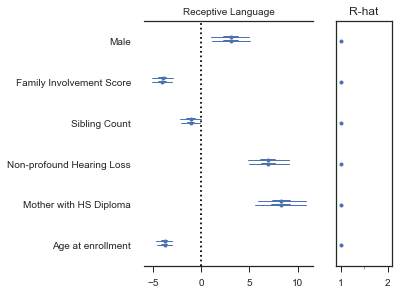

In [250]:
forestplot(expressive_vocab_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

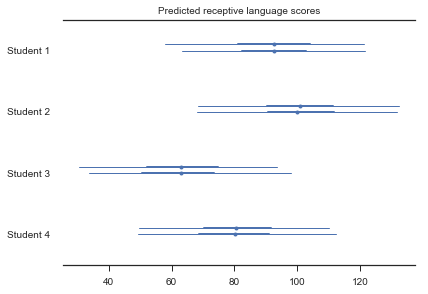

In [251]:
forestplot(expressive_vocab_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Receptive Vocabulary Model

In [252]:
receptive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Receptive Vocabulary')]

In [253]:
receptive_vocab_4 = generate_model(receptive_vocab_dataset, 4)

In [254]:
with receptive_vocab_4:
    
    receptive_vocab_4_trace = sample(iterations, tune=tuning)

Assigned NUTS to p_family_inv_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_family_inv_missing
Assigned NUTS to p_hl_logodds__
Assigned BinaryGibbsMetropolis to x_hl_missing
Assigned NUTS to p_mother_hs_logodds__
Assigned BinaryGibbsMetropolis to x_mother_hs_missing
Assigned NUTS to p_sib_stickbreaking__
Assigned CategoricalGibbsMetropolis to x_sib_missing
Assigned NUTS to μ_school
Assigned NUTS to σ_school_log__
Assigned NUTS to z_school
Assigned NUTS to β_race
Assigned NUTS to β
Assigned NUTS to σ_log__
Assigned NUTS to predictions
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|██████████| 2000/2000 [42:29<00:00,  1.27s/it]


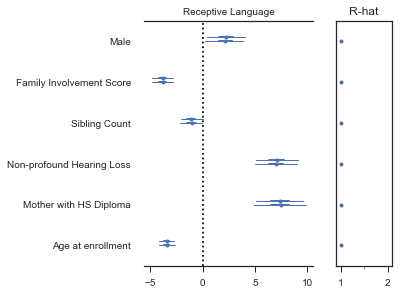

In [255]:
forestplot(receptive_vocab_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

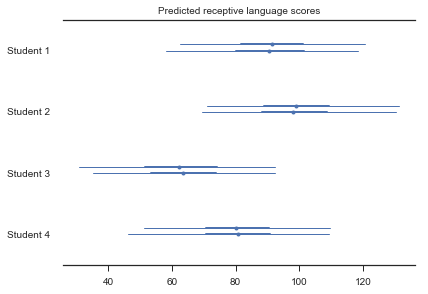

In [256]:
forestplot(receptive_vocab_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')